# Single Cell Analysis of Quenched Slides

**Question:** How does autofluorescence change over repeated quenching reactions?

**Samples:** Three normal pancrease tissue sections were processed with the cyclif IF protocol, then repeatedly quenched for 15 minutes and imaged. No anitbody was applied. Quenching solution contained 3%, 4.5% and 6% H2O2, but no difference in quenching speed or completeness was observed between the conditions.

**Method**: Slides were imaged as described above, registered and segmented based on DAPI stain. Nuclei were inflated by 5 pixels to roughly capture cytoplasmic signal.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import matplotlib
import seaborn as sns
#sns.set()
matplotlib.rcParams.update({'font.size': 15})
import umap
from sklearn.preprocessing import scale
import scanpy as sc
import umap.plot

In [2]:
#set location of files
codedir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation'
os.chdir(codedir)
#os.listdir()

# Import and Filter Data

In [3]:
#import single cell intensity data
ls_sample = ['4165NPanc-74','4165NPanc-76','4165NPanc-78']
df_data = pd.DataFrame()
df_xy=pd.DataFrame()
for s_sample in ls_sample:
    print(s_sample)
    df = pd.read_csv(f'{codedir}/Data/Quench/features_{s_sample}_FilteredMeanIntensity_DAPI6_DAPI1.csv',index_col=0)
    df['sample'] = s_sample
    df_data = df_data.append(df)
    df_xy = df_xy.append(pd.read_csv(f'{codedir}/Data/Quench/features_{s_sample}_CentroidXY.csv',index_col=0))


4165NPanc-74
4165NPanc-76
4165NPanc-78


In [4]:
#select nucleus and 5 pixels around nucleus (perinuc5) mean intensity features
ls_cyto = sorted(df_data.columns[(df_data.columns.str.contains('perinuc5')) & (~df_data.columns.str.contains('DAPI')) & (~df_data.columns.str.contains('R6'))]) 
ls_nuc = [item.split('_')[0] + '_nuclei' for item in ls_cyto] 
ls_cyto = ls_cyto + ['sample']
df_cyto = df_data.loc[:,ls_cyto].dropna()
df_nuc = df_data.loc[:,ls_nuc].dropna()
df_both = df_data.loc[:,ls_cyto+ls_nuc].dropna()

In [5]:
# analyze only channel 2 nd 3 (488 and 555)
df_af = df_both.loc[:,(df_both.columns.str.contains('c2') |  df_both.columns.str.contains('sample'))] #df_both.columns.str.contains('c3') | #shading artifact

#sort column names
df_af = df_af.loc[:,sorted(df_af.columns)]

In [6]:
# save as csv for scanpy
df_af.columns = [item.replace('_nuclei','_nuc') for item in df_af.columns]
df_af.columns = [item.replace('_perinuc5','_cyt') for item in df_af.columns]
df_af.drop('sample',axis=1).to_csv(f'{codedir}/Data/Quench/features_4165NPanc_AF_scanpy.csv')

# Scanpy

single cell analysis

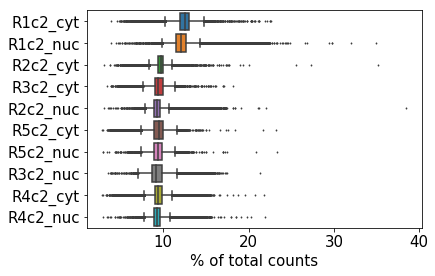

In [7]:
filename = f'{codedir}/Data/Quench/features_4165NPanc_AF_scanpy.csv'
adata = sc.read_csv(filename)
fig,ax=plt.subplots()
sc.pl.highest_expr_genes(adata, n_top=12,ax=ax)
fig.savefig(f'{codedir}/Figures/4165NPanc/4165NPanc_RankedExpression.png',dpi=200)

#adata.obs
adata.obs['tissue'] = [item.split('_scene')[0].split('4165')[1] for item in adata.obs.index]

/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'tissue' as categorical


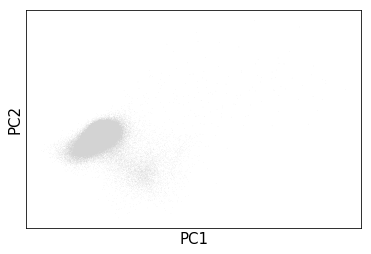

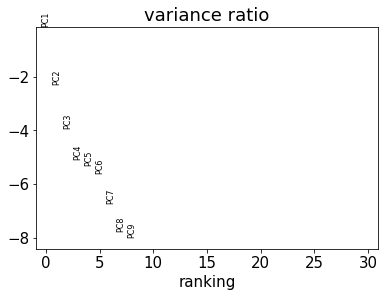

In [8]:
#log transform, batch correct reduce dimensionality (PCA)
sc.pp.log1p(adata)
adata.raw = adata
#sc.pp.scale(adata, max_value=50) don't scale since all are same exposure

#remove batch effect
sc.pp.combat(adata,key='tissue')

#reduce dimensionality
sc.tl.pca(adata, svd_solver='auto')
fig, ax = plt.subplots()
sc.pl.pca(adata,ax=ax)
sc.pl.pca_variance_ratio(adata, log=True)


In [68]:
#raw umap
filename = f'{codedir}/Data/Quench/features_4165NPanc_AF_scanpy.csv'
rdata = sc.read_csv(filename)
rdata.obs['tissue'] = [item.split('_scene')[0].split('4165')[1] for item in rdata.obs.index]
rdata.raw = rdata
#log transform, reduce dimensionality (PCA)
sc.pp.log1p(rdata)

#don't remove batch effect
#sc.pp.combat(adata,key='tissue')

#reduce dimensionality
sc.tl.pca(rdata, svd_solver='auto')
sc.pp.neighbors(rdata, n_neighbors=10, n_pcs=9)
sc.tl.umap(rdata)


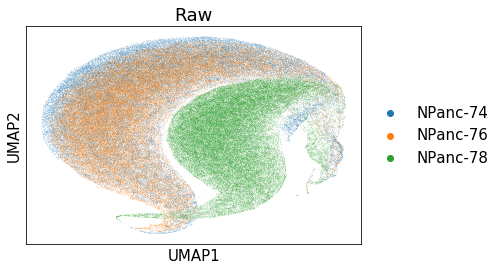

<Figure size 432x288 with 0 Axes>

In [55]:
#umap plot
figname = f'{codedir}/Figures/4165NPanc/4165NPanc_UmapRaw.png'
fig = sc.pl.umap(rdata, color='tissue',save=figname,return_fig=True,title='Raw')

plt.show(fig)
plt.tight_layout()
fig.savefig(figname)

In [9]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=9)
sc.tl.umap(adata)

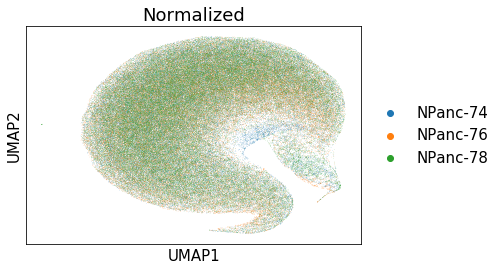

In [54]:
#umap plot
figname = f'{codedir}/Figures/4165NPanc/4165NPanc_UmapBatch.png'
fig = sc.pl.umap(adata, color='tissue',use_raw=True,save=figname,return_fig=True,title='Normalized')
plt.show(fig)
fig.savefig(figname)

In [13]:
#cluster
sc.tl.leiden(adata, resolution = 0.3)

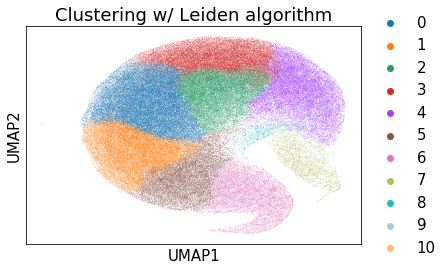

In [57]:
# umap plus clustering result 
figname = f'{codedir}/Figures/4165NPanc/4165NPanc_UmapLeiden.png'
fig = sc.pl.umap(adata, color='leiden',save=figname,return_fig=True,title='Clustering w/ Leiden algorithm')
plt.show(fig)
fig.savefig(figname)

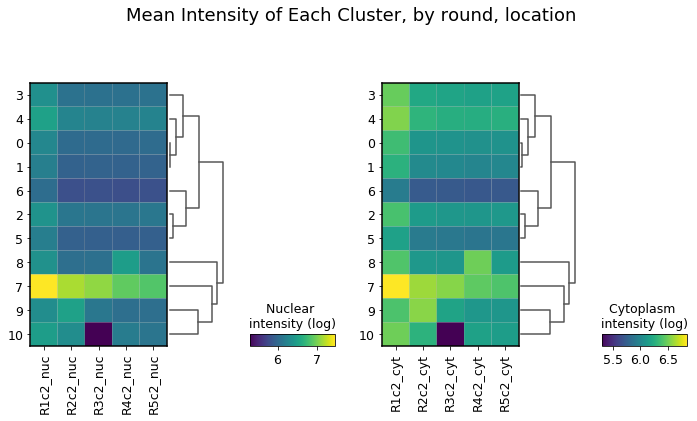

In [72]:
# inspect clusters
marker_genes = ['R1c2_nuc','R2c2_nuc','R3c2_nuc','R4c2_nuc','R5c2_nuc']
marker_genes_cyt = ['R1c2_cyt','R2c2_cyt','R3c2_cyt','R4c2_cyt','R5c2_cyt']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1_dict = sc.pl.matrixplot(adata, marker_genes, groupby='leiden', ax=ax1,show=False,dendrogram=True, cmap='viridis', use_raw=True, colorbar_title='Nuclear \nintensity (log)')
ax2_dict = sc.pl.matrixplot(adata, marker_genes_cyt, groupby='leiden',ax=ax2,show=False, dendrogram=True, cmap='viridis', use_raw=True, colorbar_title='Cytoplasm \nintensity (log)')
fig.suptitle(f'Mean Intensity of Each Cluster, by round, location')
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/4165NPanc/4165NPanc_MatrixPlot_Leiden.png',dpi=200)


/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/napari/__init__.py:44: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.6. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


leiden


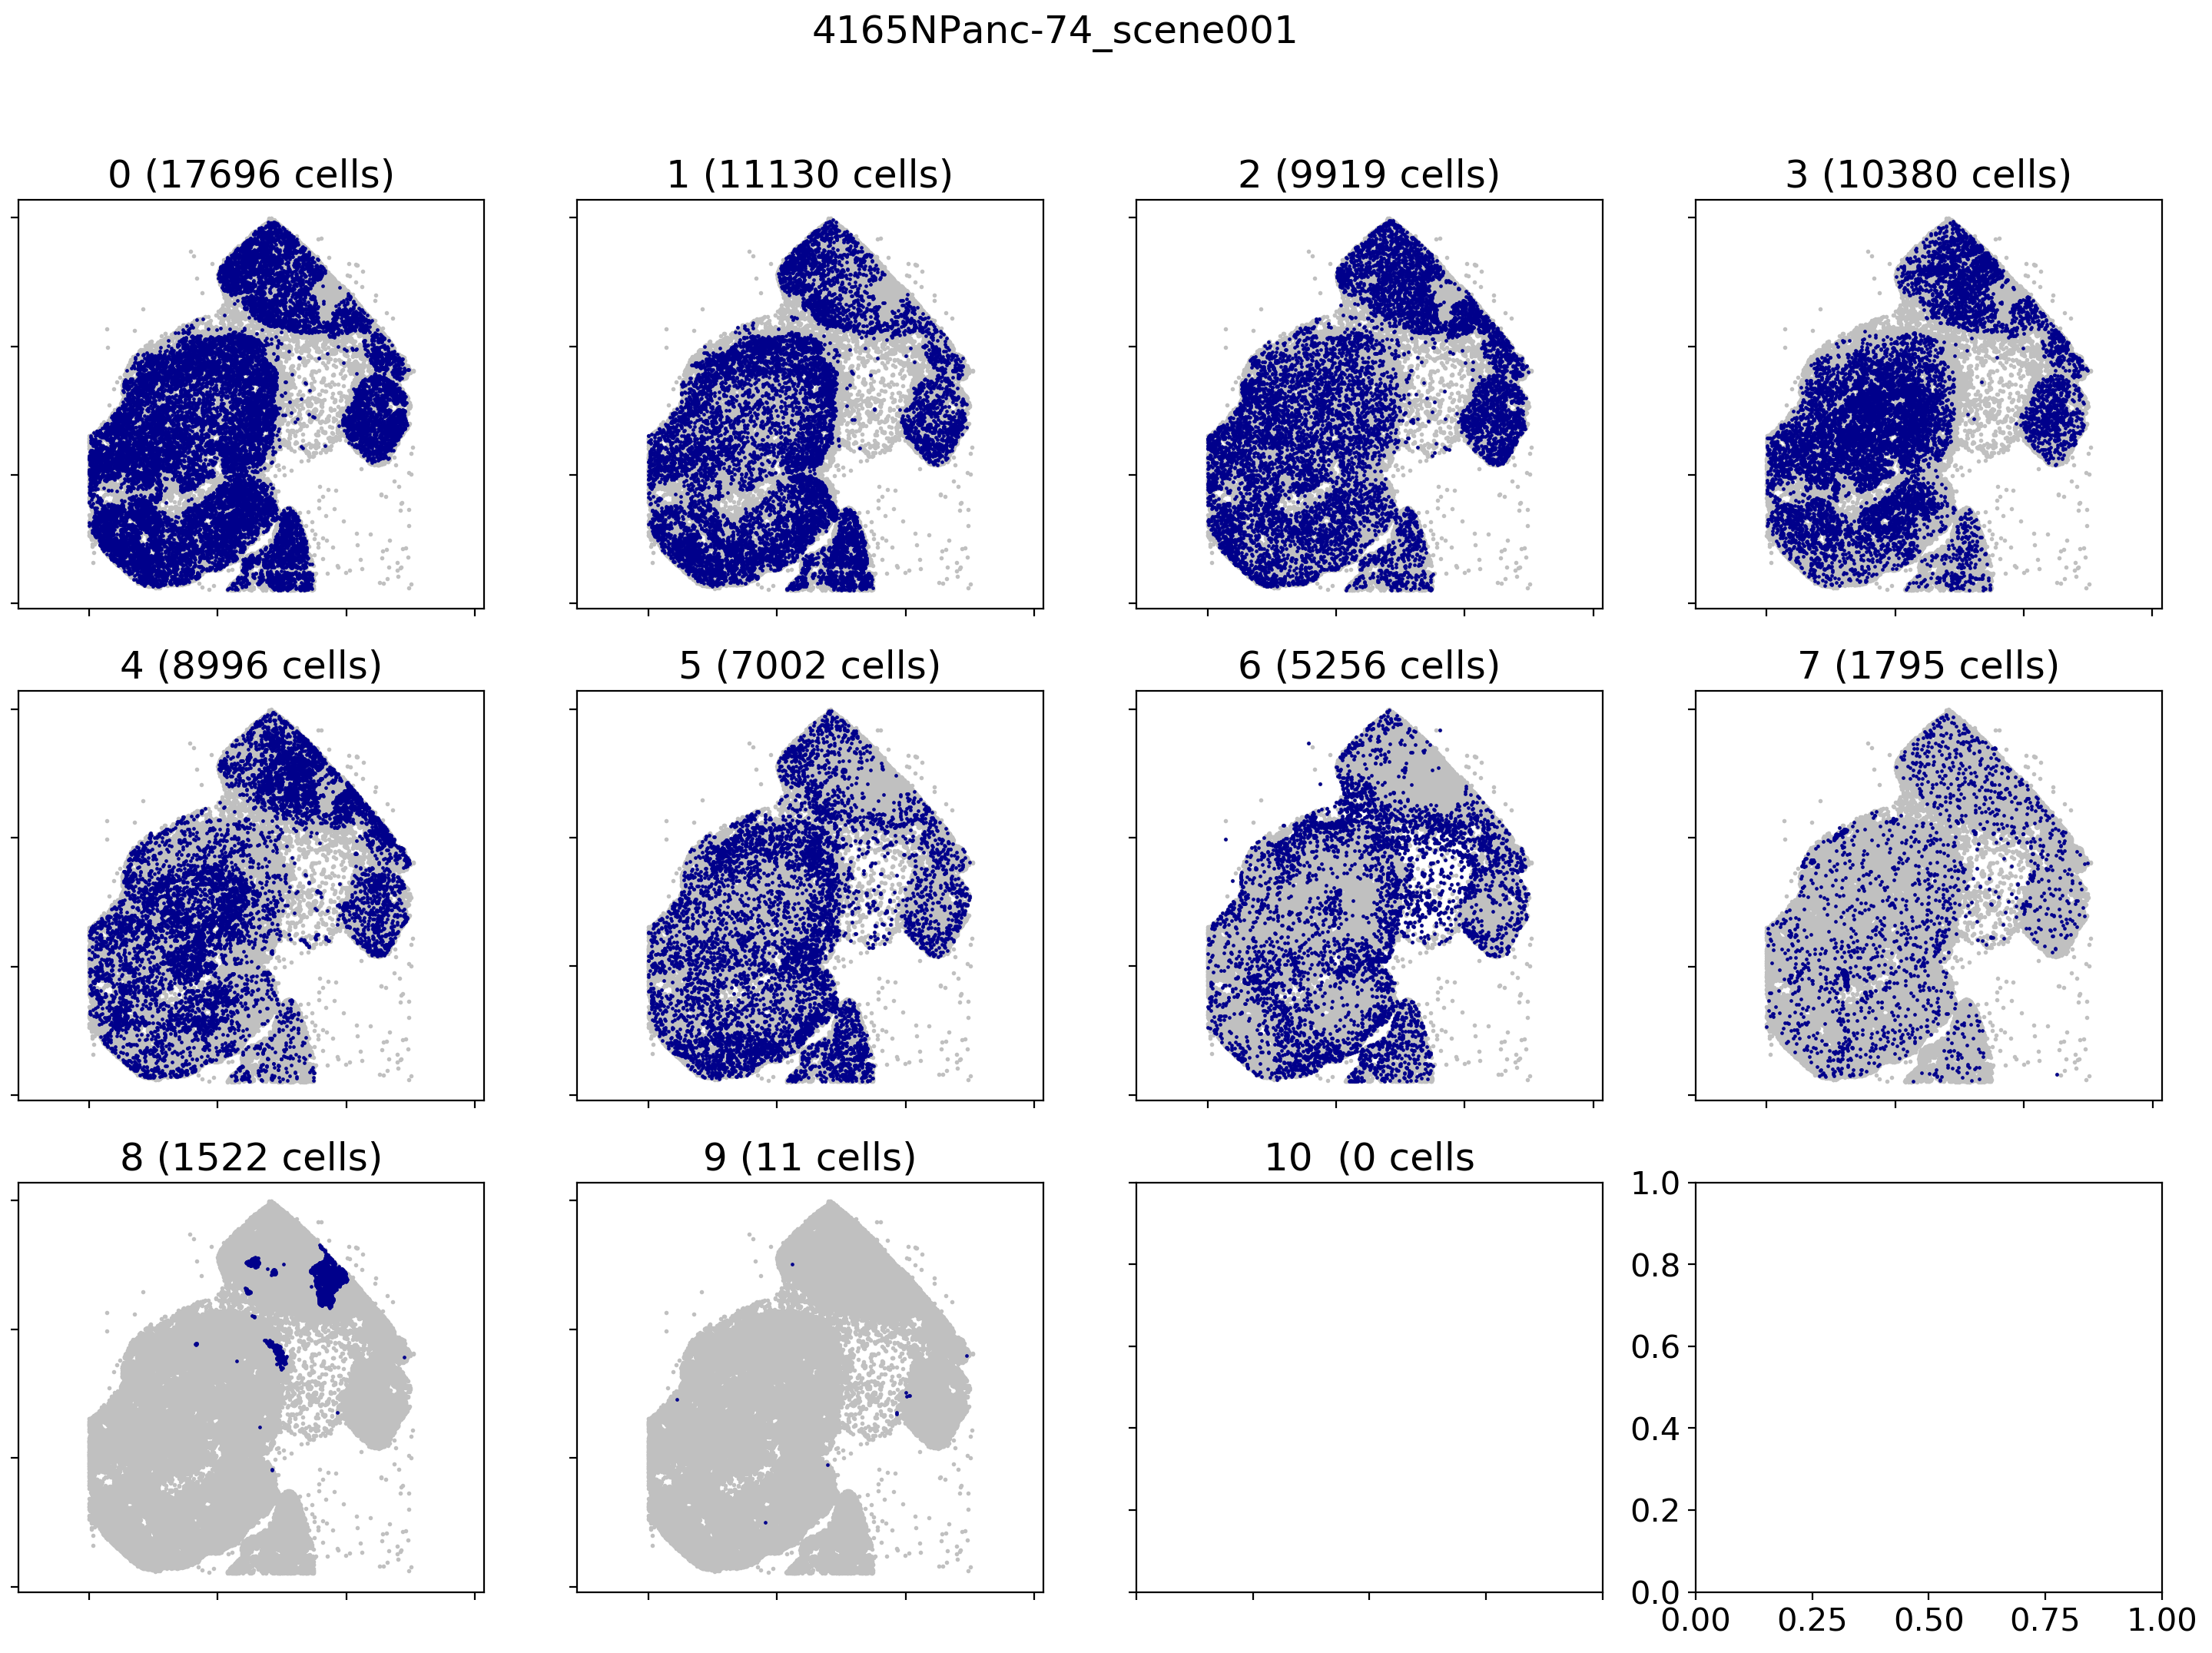

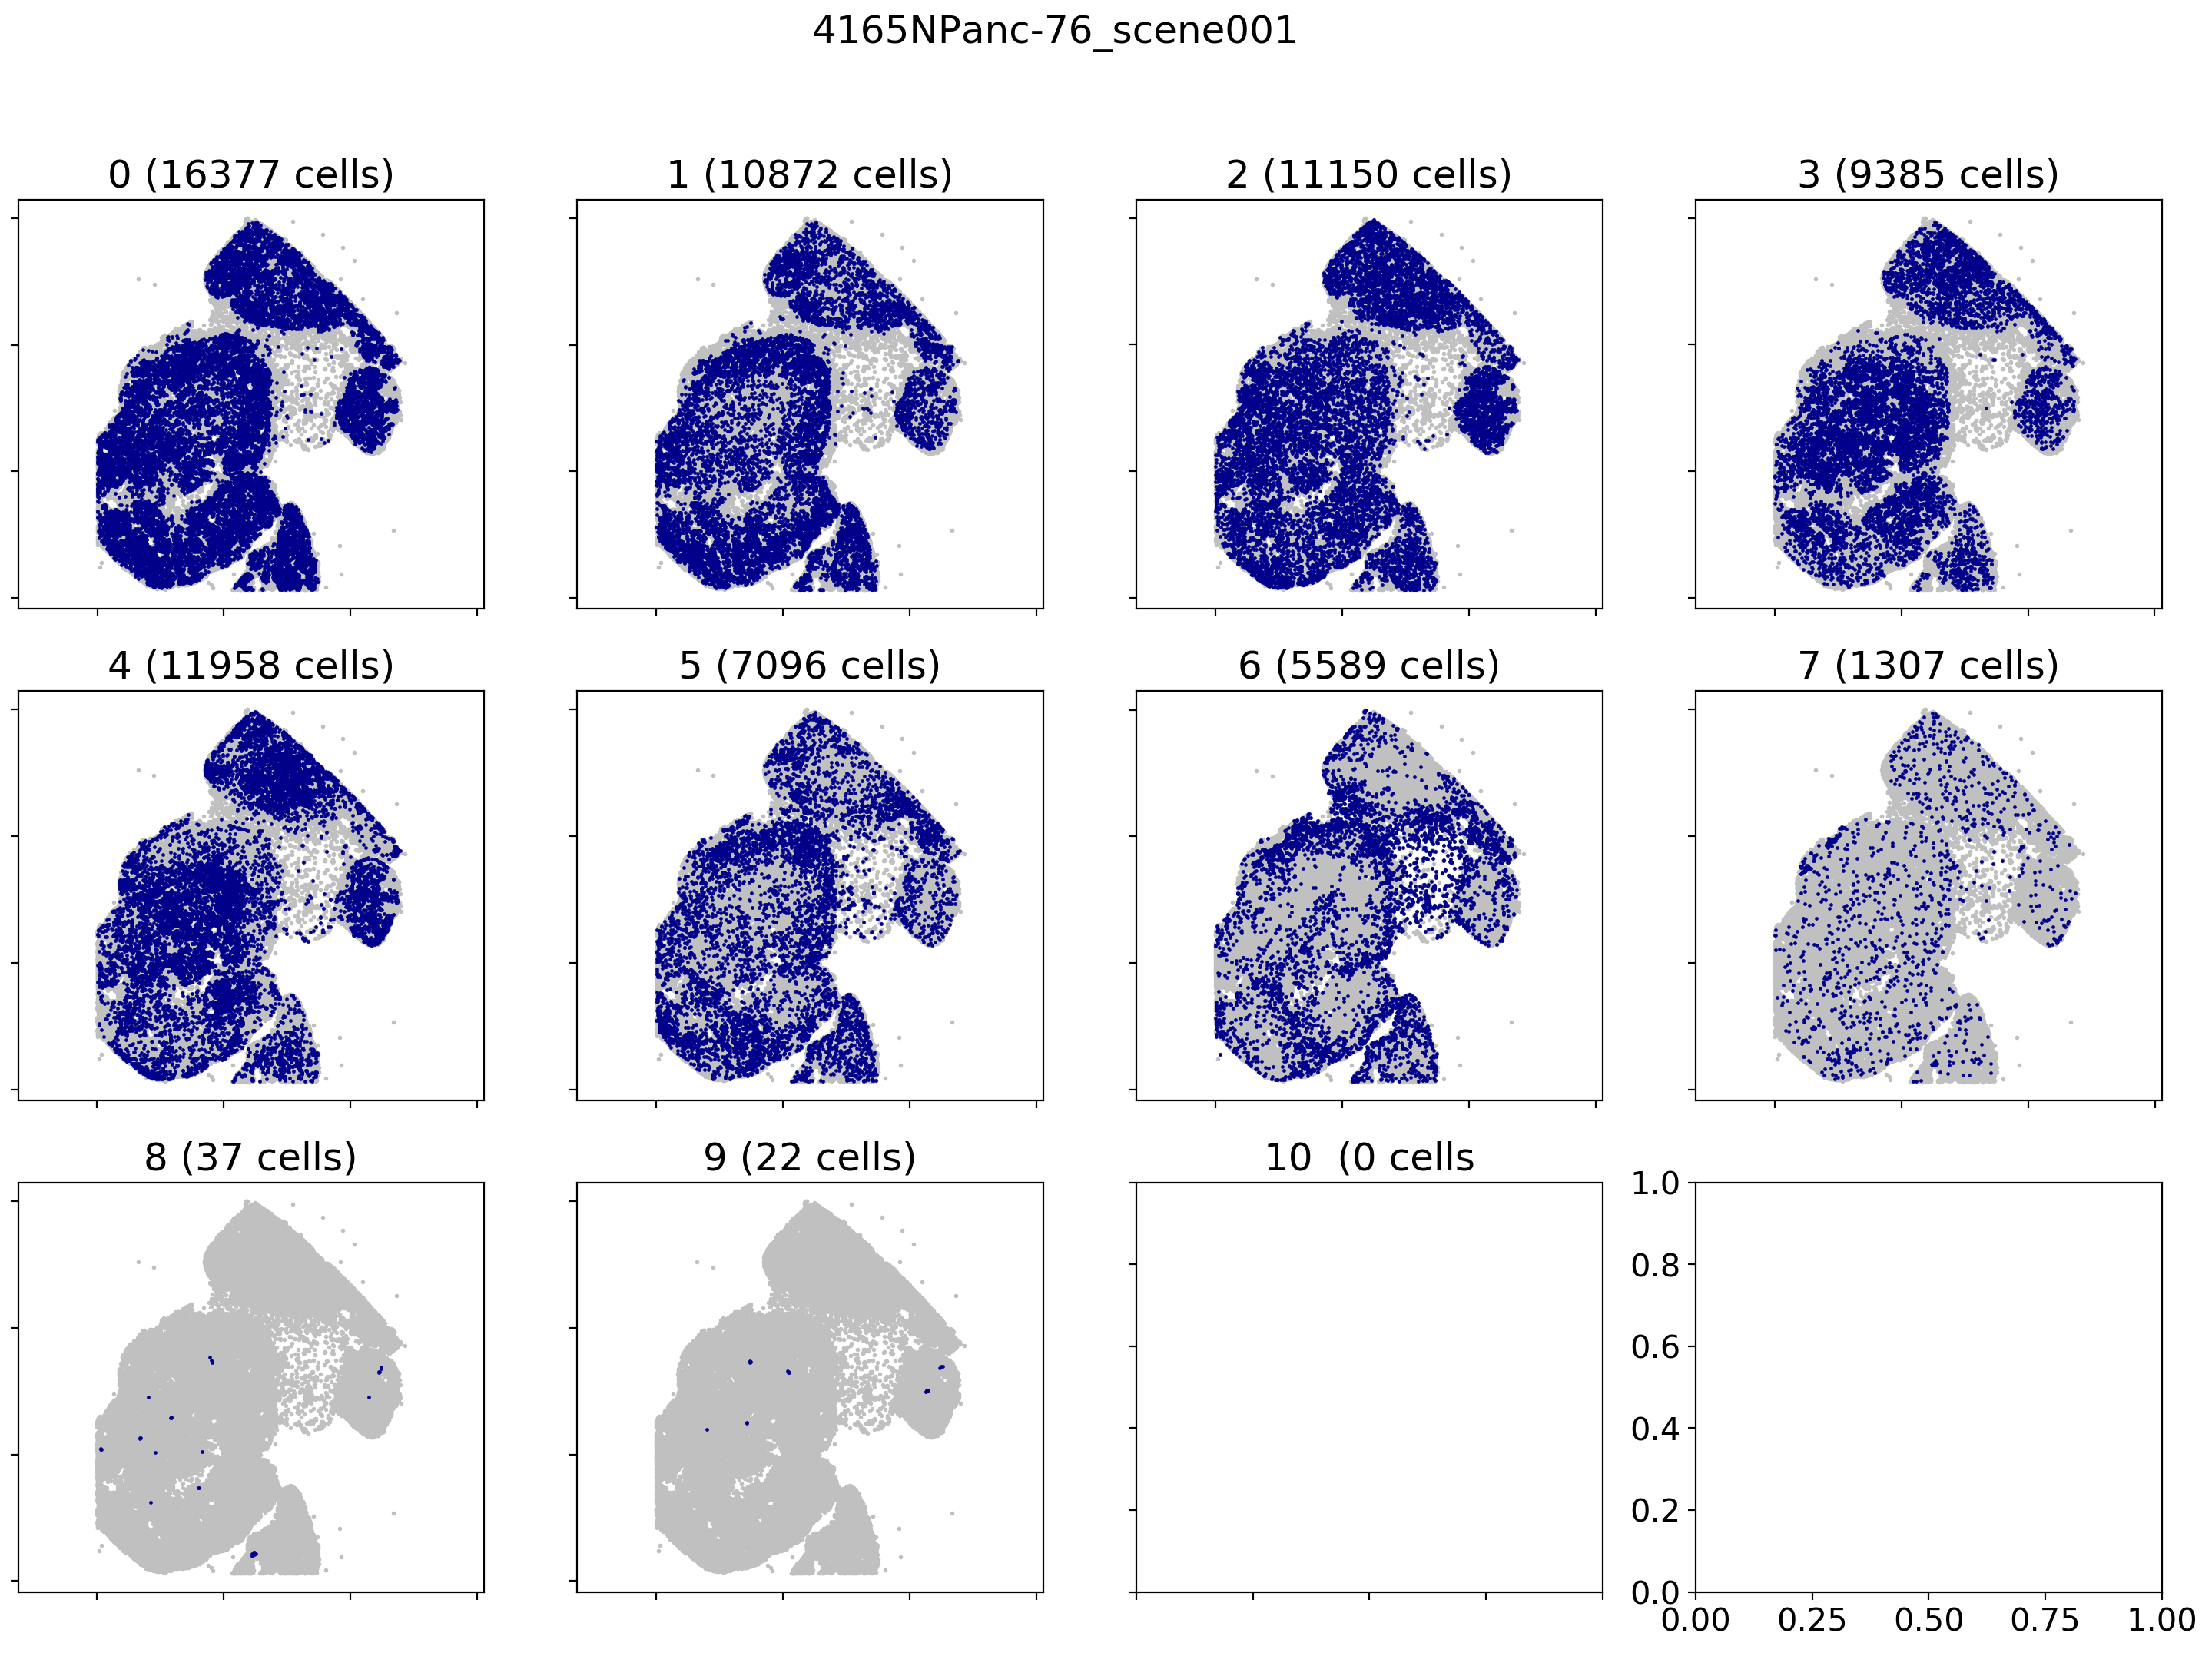

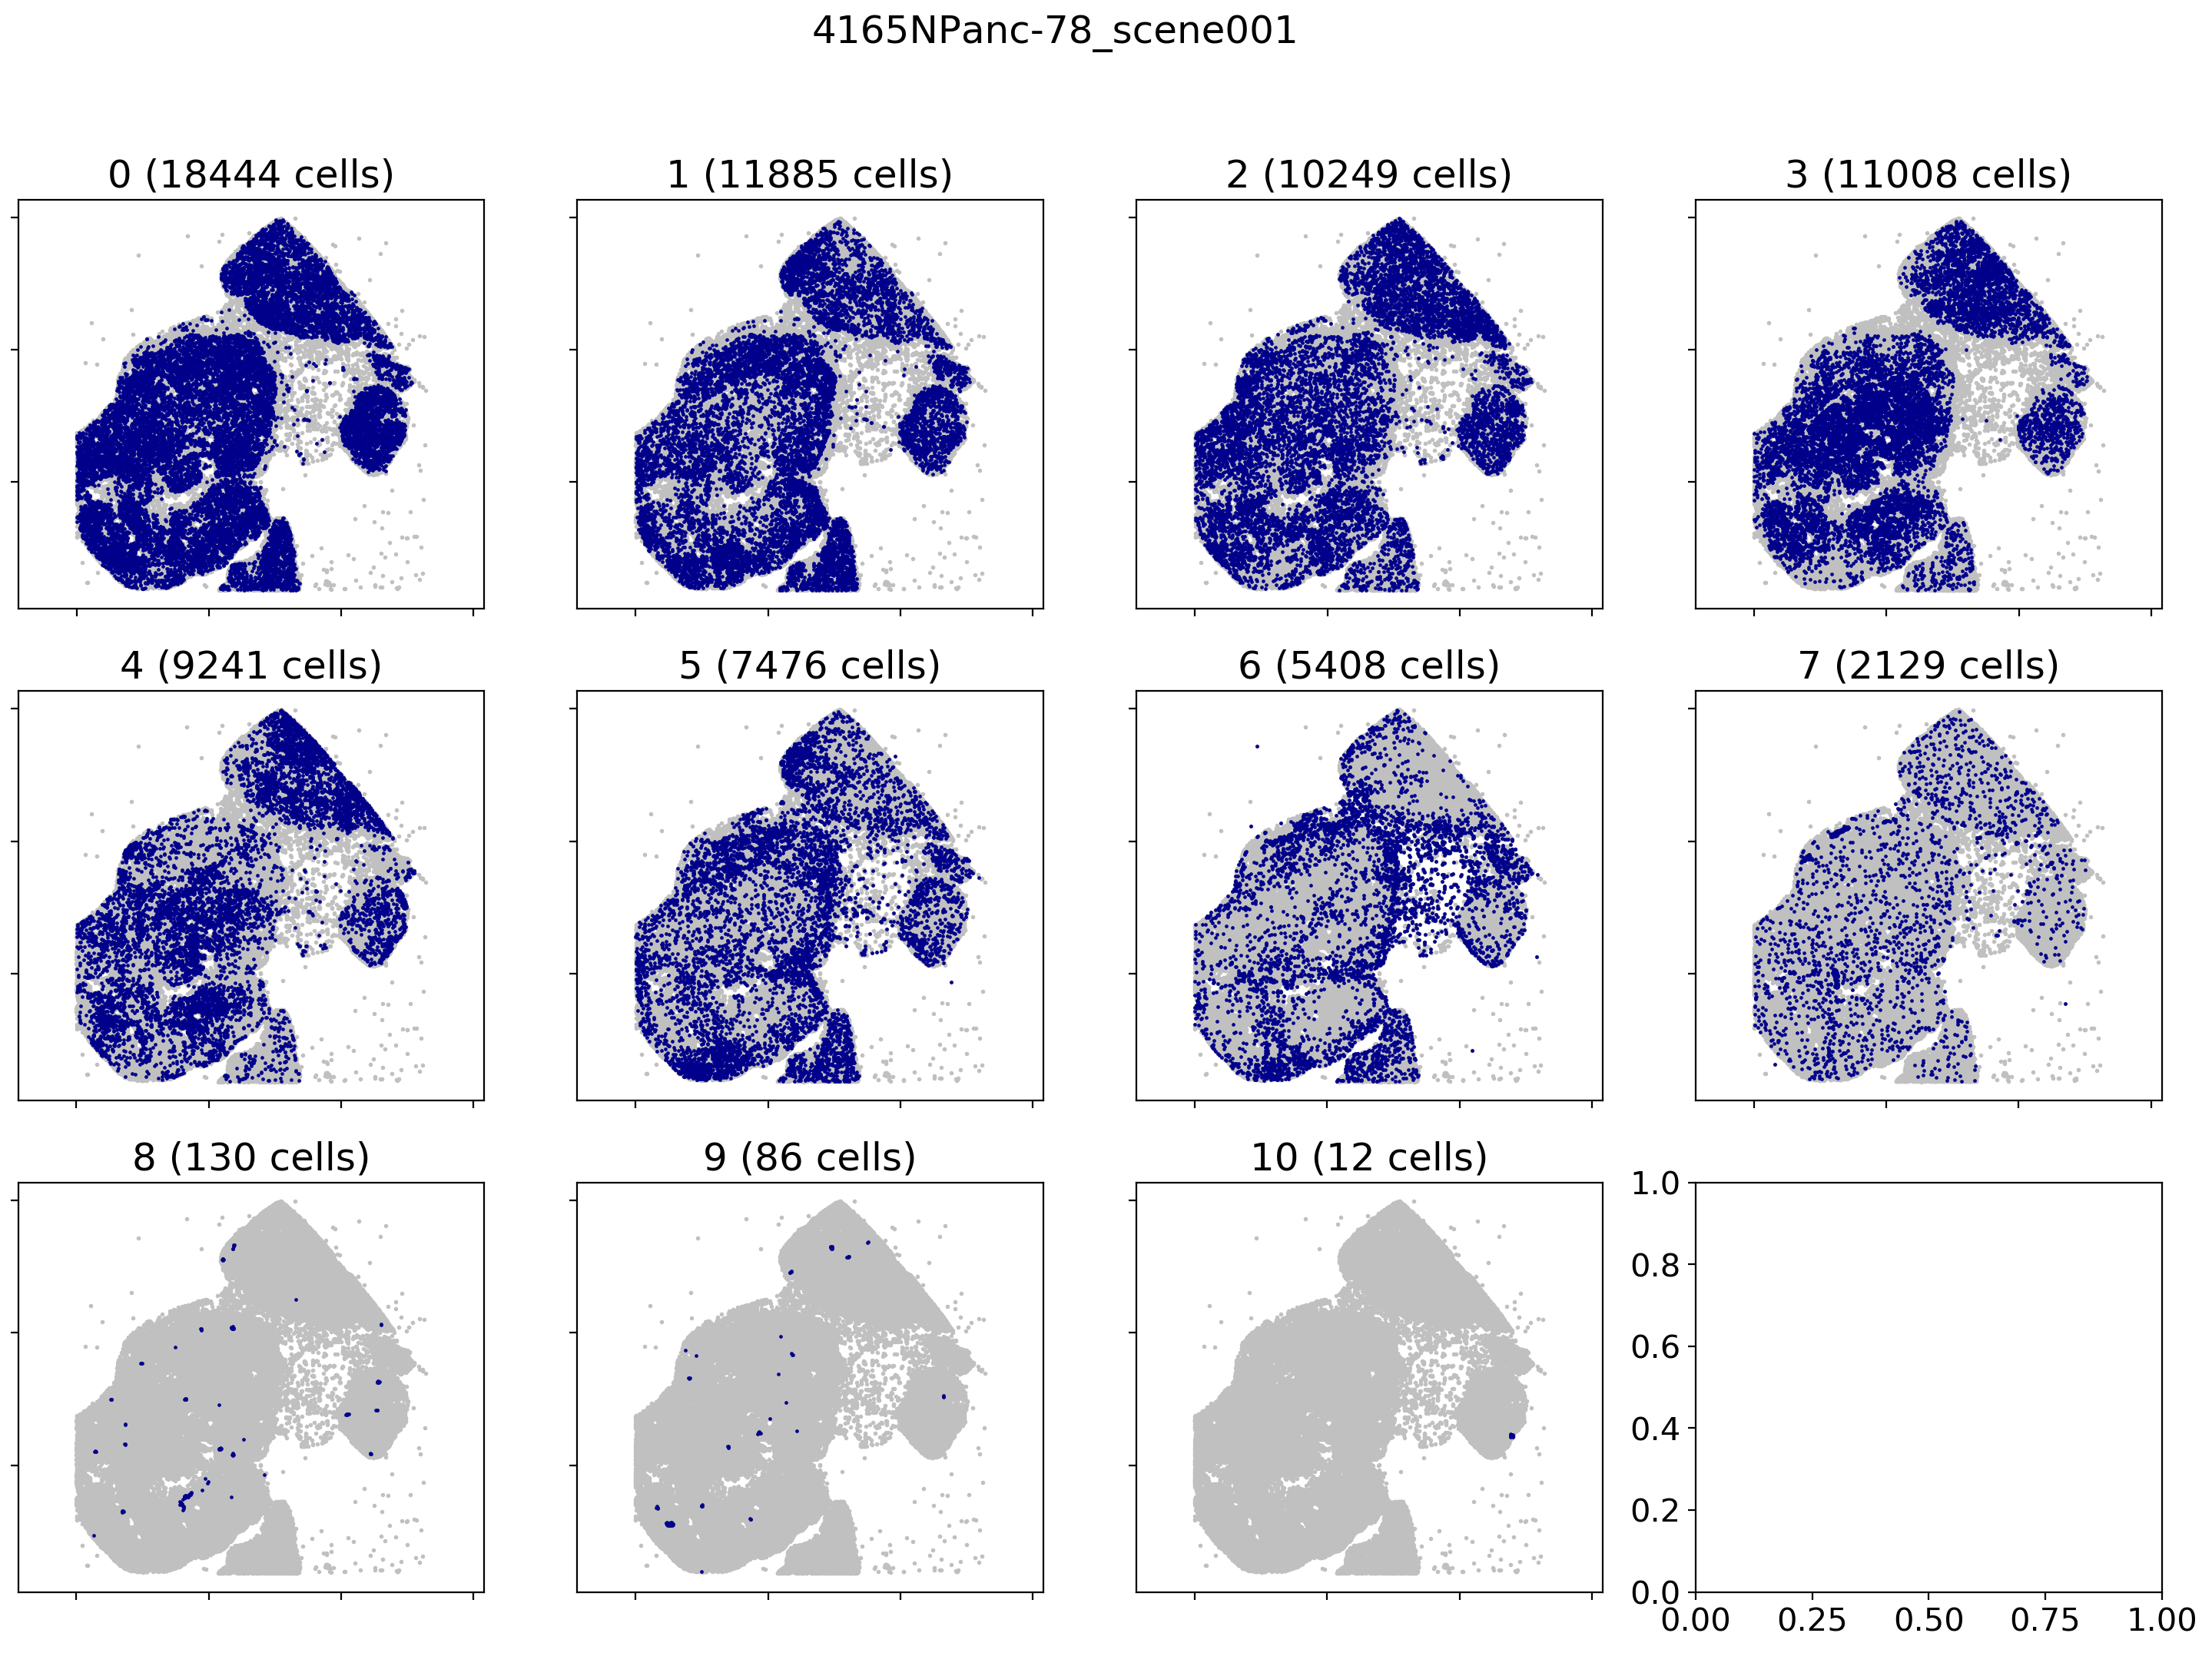

In [16]:

from mplex_image import visualize as viz
import importlib
importlib.reload(viz)
df_lei = pd.DataFrame(adata.obs['leiden'],dtype='int64')
df_lei['slide_scene'] = [item.split('_cell')[0] for item in df_lei.index]
ls_fig = viz.plot_clusters(df_lei,df_xy)
for idx, fig in enumerate(ls_fig):
    fig.savefig(f'{codedir}/Figures/4165NPanc/SpatialPlots_{ls_sample[idx]}_Leiden.png')
    plt.show(fig)

In [18]:
#save results
results_file = f'{codedir}/Data/4165NPanc_AF_norm_leiden.h5ad'  # the file that will store the analysis results
adata.write(results_file)

In [69]:
#save as csv
df_data = pd.DataFrame(adata.X, columns = adata.var.index, index = adata.obs.index)
df_raw = pd.DataFrame(rdata.raw.X, columns = adata.var.index, index = adata.obs.index)

In [70]:
#save to csv
df_data.merge(adata.obs,left_index=True,right_index=True).to_csv(f'{codedir}/Data/4165NPanc_AF_norm_leiden.csv')
df_raw.merge(adata.obs,left_index=True,right_index=True).to_csv(f'{codedir}/Data/4165NPanc_AF_raw_leiden.csv')

# umap visualization

In [59]:
#umap projection raw data
mapper_af = umap.UMAP().fit(df_af.drop('sample',axis=1).values)

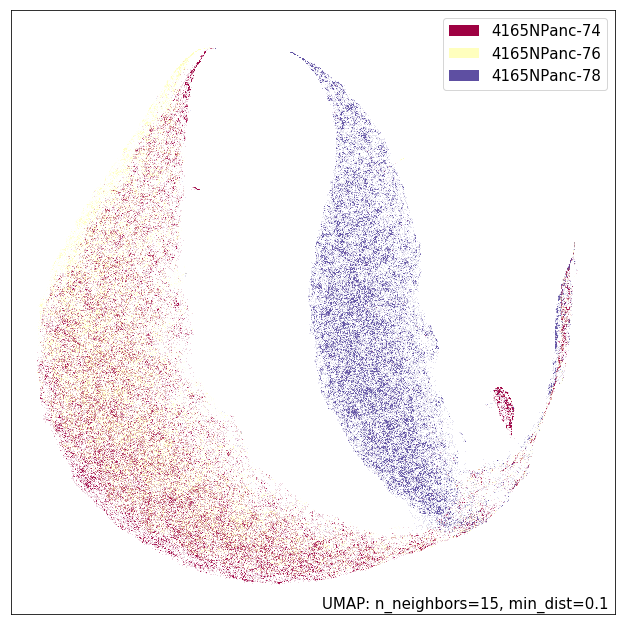

In [62]:
#color by slide (3%, 4.5% and 6% hydrogen peroxide)
fig = umap.plot.points(mapper_af, labels=df_af.loc[:,'sample'])
fig=plt.gcf()
fig.savefig(f'{codedir}/Figures/4165NPanc/4165NPanc_UmapRaw_larger.png')

# Histograms

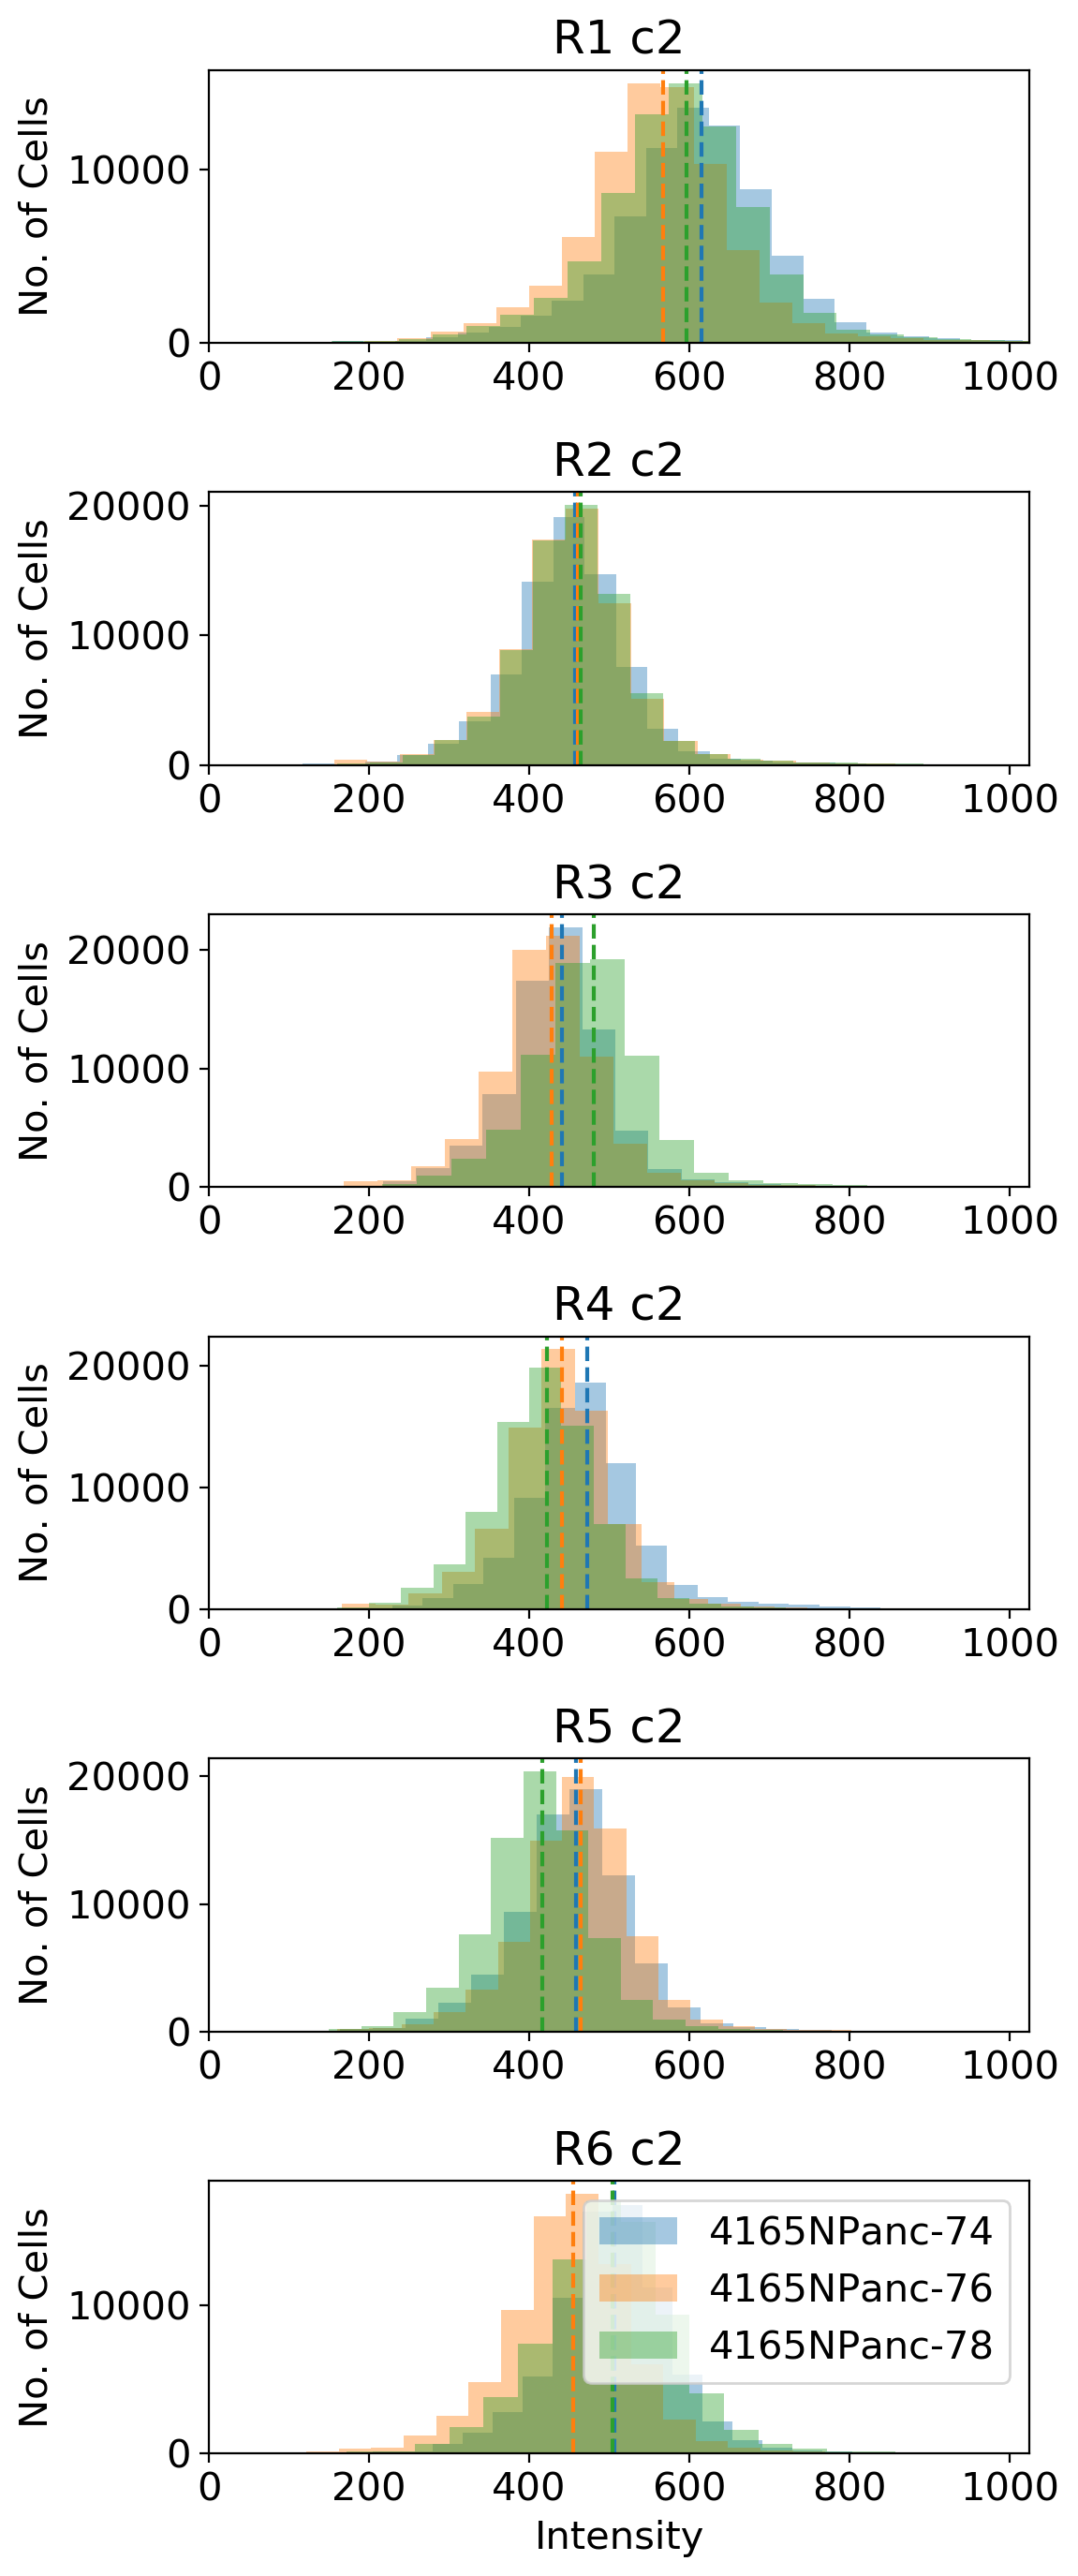

In [127]:
#histograms
df_plot = df_cyto
d_result = {}
for s_channel in ['c2','c3','c4','c5']:
    #plot single cell mean intensity
    df_channel = df_plot.loc[:,df_plot.columns.str.contains(f'{s_channel}_')]
    fig,ax = plt.subplots(6,1,figsize=(6,14),dpi=200)
    ax=ax.ravel()
    for idxs, s_sample in enumerate(ls_sample):
        df_sample = df_channel[df_channel.index.str.contains(s_sample)]
        df_sample_diff = pd.DataFrame(index=df_sample.index)        
        for idx, s_round in enumerate(['R1','R2','R3','R4','R5','R6']):
            df_round = df_sample.loc[:,df_sample.columns.str.contains(f'{s_round}c')]
            if idx == 0:
                i_max = np.quantile(df_round,.99)
            sns.distplot(df_round,bins=500,kde=False,ax=ax[idx],label=s_sample)
            i_mean = df_round.mean() 
            ax[idx].axvline(i_mean[0],ymin=0,ymax=1,color=f'C{idxs}',linestyle='--')
            ax[idx].set_xlabel('')  
            ax[idx].set_title(f'{s_round} {s_channel}')
            ax[idx].set_ylabel('No. of Cells')
            ax[idx].set_xlim(0,i_max)
            if s_round != 'R1':
                df_sample_diff[f'{s_round} - {s_last}'] = df_round.values - df_last.values
            df_last = df_round
            s_last = s_round
        ax[idx].legend()  
        ax[idx].set_xlabel(f'Intensity')
        d_result.update({s_sample:df_sample_diff})
    plt.tight_layout()
    fig.savefig(f'{codedir}/Figures/4165NPanc/SingleCellDist_{s_channel}.png')
    if s_channel != 'c2':
        plt.close(fig)
